Authors: Antoine A. Ruzette
Date: 2025-02-21

This notebook processes cell measurement tables exported from QuPath to plot the spatial distribution of cell-level pixel intensity in relation to a modelled stromal border. It also supports the comparison of confusion matrices between threshold- and machine learning-based cell classification.

Contains the code to plot data from images containing four channels: DAPI (nuclei), TRITC (cytokeratin), FITC (fibronectin) and CY5 (Ki67). 

In [3]:
import os
import pandas as pd
import numpy as np
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import natsort
import re
from matplotlib.ticker import LogFormatterSciNotation
from fitter import Fitter, get_common_distributions, get_distributions

# colorblind-friendly colors
CB_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']

## Back-end functions

In [2]:
def load_and_preprocess_files(folder_path, file_paths, expected_columns):
    """
    Load and preprocess CSV files.

    Args:
        folder_path (str): Path to the folder containing CSV files.
        file_paths (list): List of file names.
        expected_columns (dict): Dictionary mapping expected column keys to possible names.

    Returns:
        list: A list of processed DataFrames (one per image).
        dict: Column mapping for use in plotting.
    """
    dfs = []
    final_column_mapping = {}

    for image in file_paths:
        print(f"\n🔹 Processing: {image}")
        file_path = os.path.join(folder_path, image)

        # Load CSV to check available columns first
        try:
            df_sample = pd.read_csv(file_path, nrows=1)
            available_columns = df_sample.columns.tolist()
            print(f"✅ Available Columns: {available_columns}")
        except Exception as e:
            print(f"❌ Error loading {image}: {e}")
            continue

        # Dynamically map expected column names to available ones
        column_mapping = {}
        for key, possible_names in expected_columns.items():
            for name in possible_names:
                if name in available_columns:
                    column_mapping[key] = name
                    break
            else:
                print(f"⚠️ Warning: {key} column not found in {image}. Skipping.")

        if not column_mapping:
            print(f"⚠️ Skipping {image} as no expected columns were found.")
            continue

        # Reload dataframe with only found columns
        try:
            df = pd.read_csv(file_path, usecols=list(column_mapping.values()))
        except Exception as e:
            print(f"❌ Error loading selected columns in {image}: {e}")
            continue

        # Skip this file if essential columns are missing
        essential_columns = ["DAPI", "Ki67_647"]
        missing_essential = [col for col in essential_columns if col not in column_mapping]
        if missing_essential:
            print(f"⚠️ Skipping {image} due to missing essential columns: {missing_essential}")
            continue

        # Remove outliers dynamically (only for present columns)
        outlier_limits = {}
        for key in ["DAPI", "Ki67_647", "KER_488", "FN_568"]:
            if key in column_mapping:
                col_name = column_mapping[key]
                p01 = df[col_name].quantile(0.01)
                p99 = df[col_name].quantile(0.99)
                outlier_limits[col_name] = (p01, p99)

        print(f"📊 Outlier Thresholds: {outlier_limits}")

        # Filter outliers
        df_no_outlier = df.copy()
        for col, (p01, p99) in outlier_limits.items():
            df_no_outlier = df_no_outlier[(df_no_outlier[col] >= p01) & (df_no_outlier[col] <= p99)]

        if df_no_outlier.empty:
            print(f"⚠️ Skipping {image} as it became empty after outlier removal.")
            continue

        # ✅ Store actual filename instead of "1G", "2G" etc.
        df_no_outlier["Image"] = os.path.splitext(os.path.basename(image))[0]

        dfs.append(df_no_outlier)

        # Save column mapping for later use
        final_column_mapping = column_mapping  

    if dfs:
        return dfs, final_column_mapping
    else:
        print("⚠️ No valid data loaded.")
        return [], {}


## Exploring non-gaussian distributions using the `Fitter` library

### ki67 histograms

#### Finding the right distributions; result = lognormal (4 out of 8) + 3 inv gauss which is very similar


🔹 Processing: 20252602_Image_AsPC LZ GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
✅ Available Columns: ['Image', 'Class', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'FITC KER: Nucleus: Mean', 'FITC KER: Nucleus: 

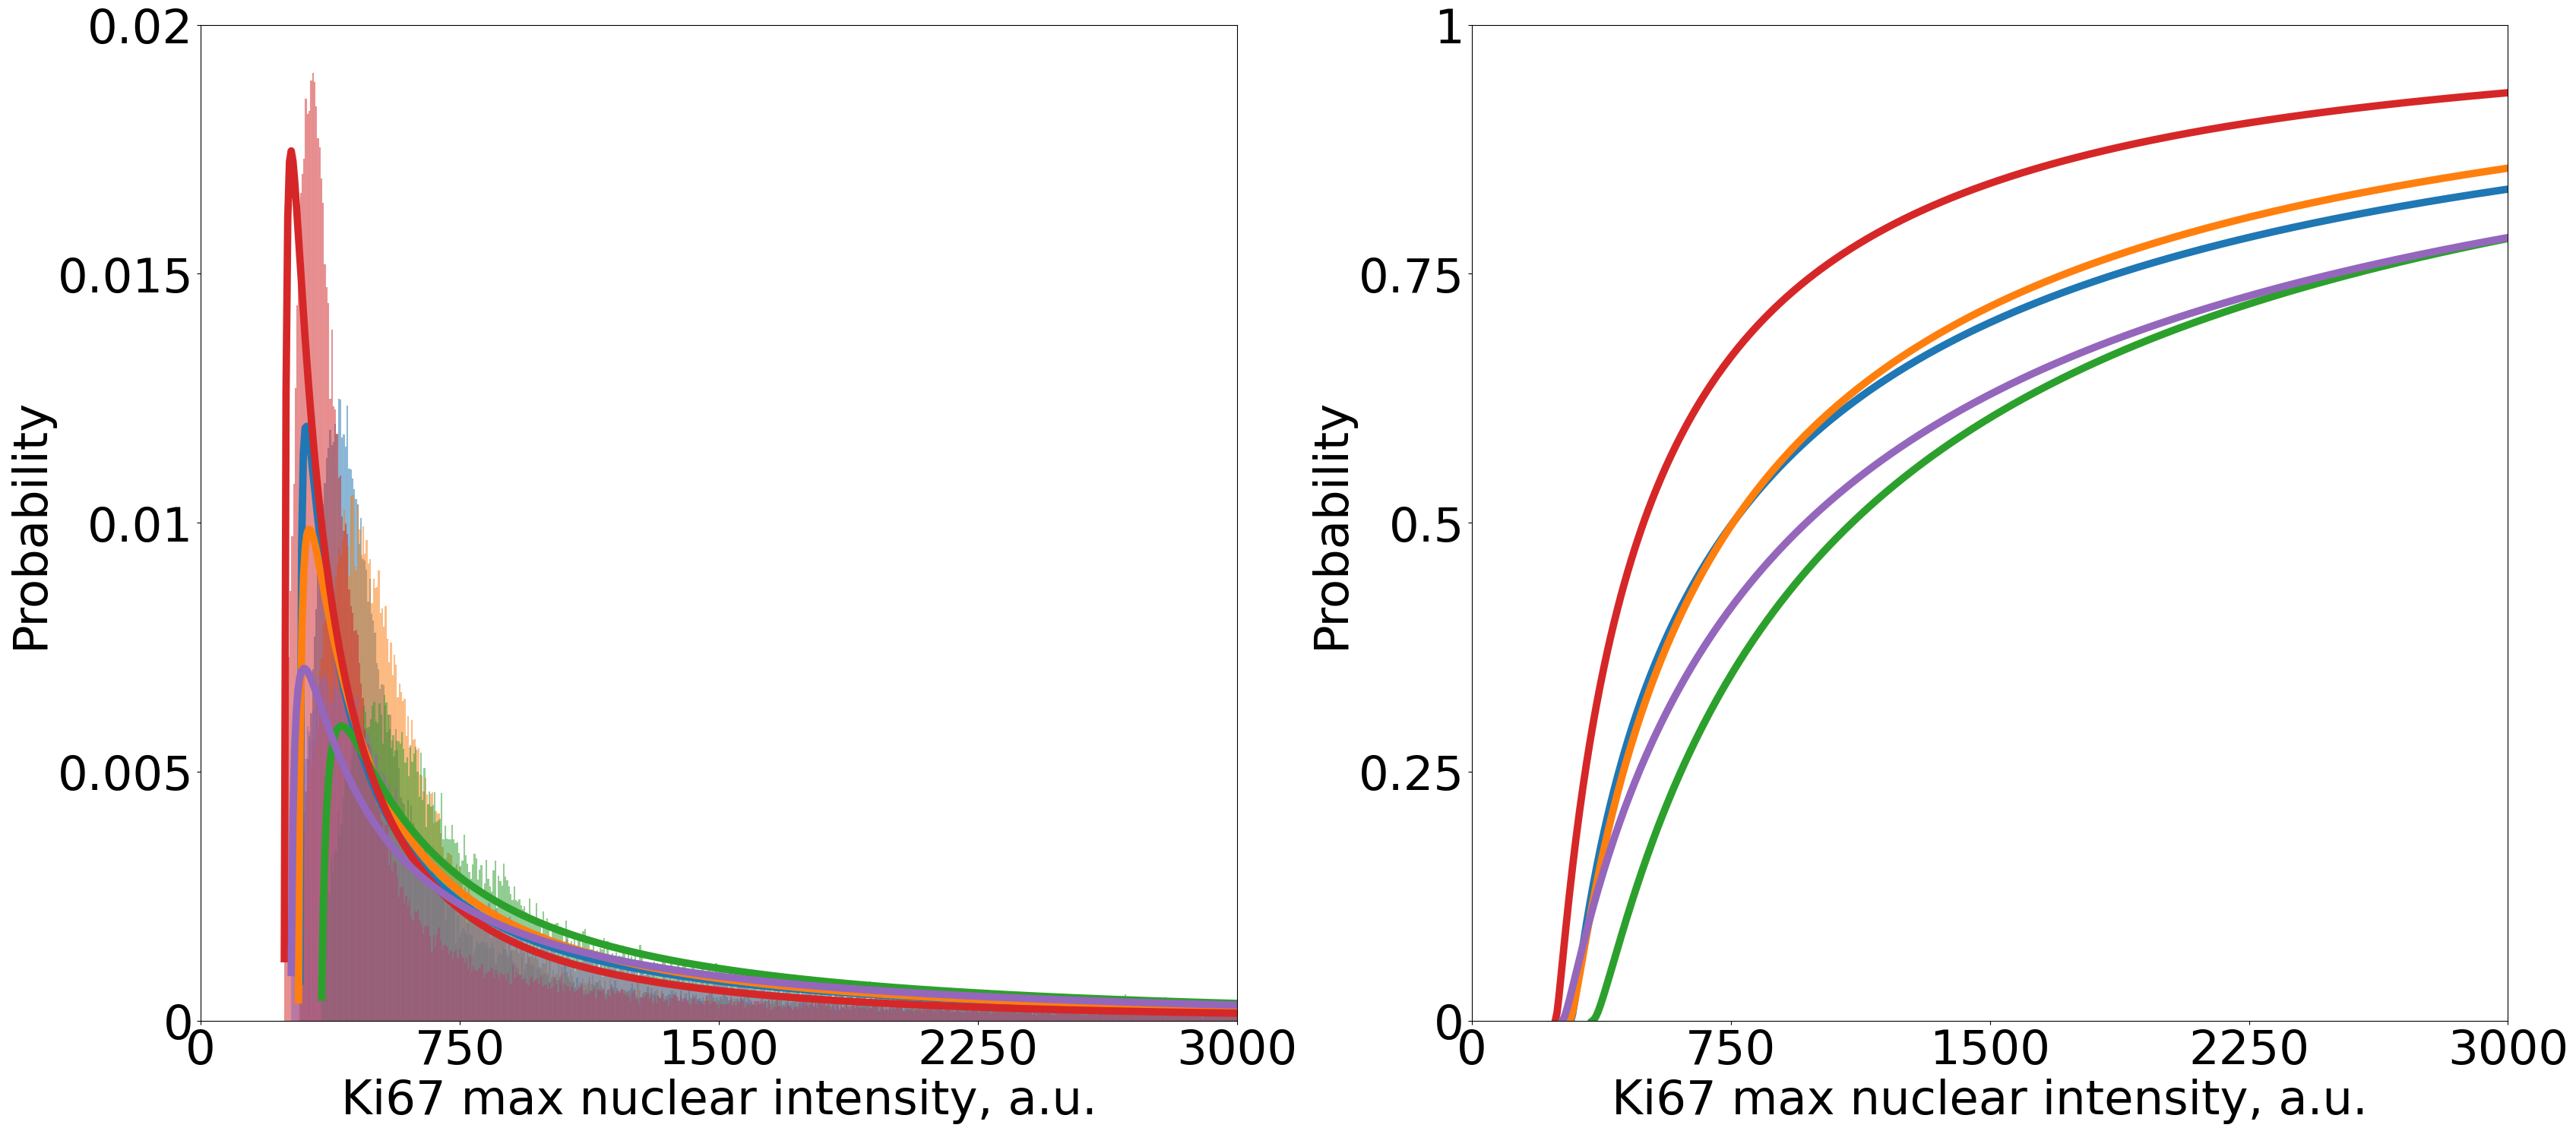

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter
from scipy.stats import lognorm

# Define folder and file paths
folder_path = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/measurements_distribution"

file_paths = [
    "20252602_Image_AsPC LZ GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv"
]

# Define bin sizes for each channel
bin_sizes = {
    "DAPI": 50,
    "Ki67_647": 5,
    "KER_488": 75,
    "FN_568": 40
}

expected_columns = {
    "Class": ["Class"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["FITC KER: Cytoplasm: Median"],
    "Ki67_647": ["CY5 Ki67: Nucleus: Max"],
    "FN_568": ["TRITC FN: Cell: Median"],
    "Nucleus_Area": ["Nucleus: Area µm^2"]
}

# Define axis labels and limits
axis_labels = {
    "PDF": "Ki67 max nuclear intensity, a.u.",
    "CDF": "Ki67 max nuclear intensity, a.u."
}
axis_limits = {
    "PDF": (0, 3000),
    "CDF": (0, 3000)
}


# Load and preprocess data
dfs, column_mapping = load_and_preprocess_files(folder_path, file_paths, expected_columns)

# Initialize plots
fig, axs = plt.subplots(1, 2, figsize=(34, 15))

# Define bin width for histogram and fitting
bin_width = bin_sizes.get("Ki67_647", 5)

for idx, df in enumerate(dfs):
    image_name = df["Image"].iloc[0]
    gem_number = f"#{idx + 1}"

    # Get relevant column name
    pNDRG1_col = column_mapping.get("Ki67_647", "Ki67_647: Nucleus: Max")

    # Define bin edges based on min and max values
    min_val = df[pNDRG1_col].min()
    max_val = df[pNDRG1_col].max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Fit log-normal distribution
    f = Fitter(df[pNDRG1_col], distributions=["lognorm"])
    f.fit()
    params = f.get_best(method="sumsquare_error").get("lognorm", {})

    # Compute fitted PDF and CDF at the same resolution as histogram
    pdf_values = lognorm.pdf(bins, *params.values())
    cdf_values = lognorm.cdf(bins, *params.values())
    pdf_values *= bin_width

    # Overlay histogram and best-fit PDF
    sns.histplot(df[pNDRG1_col], 
                 bins=bins, 
                 kde=False,
                 ax=axs[0], 
                 label=f'{gem_number}',
                 alpha=0.5,
                 stat='probability')
    axs[0].plot(bins, pdf_values, label=f"PDF {gem_number}", linewidth=7)

    # Plot CDF separately
    axs[1].plot(bins, cdf_values, label=f'CDF {gem_number}', linewidth=7)
    axs[1].set_ylim(0, 1)
# Apply formatting to match your layout
for key, ax in zip(["PDF", "CDF"], axs):
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set_ylabel('Probability', fontsize=45)
    ax.set_xlabel(axis_labels[key], fontsize=45)
    ax.tick_params(axis='both', labelsize=45)

    # Set x-axis range and define 5 evenly spaced ticks
    if key in axis_limits:
        ax.set_xlim(axis_limits[key])
        xticks = np.linspace(axis_limits[key][0], axis_limits[key][1], 5)
        ax.set_xticks(xticks)

    # Ensure y-axis tick limits apply to all panels
    yticks = ax.get_yticks()
    if len(yticks) > 5:  
        min_y, max_y = min(yticks), max(yticks)  
        yticks = np.linspace(min_y, max_y, 5)  
        ax.set_yticks(yticks)

    # Format y-tick labels to 2 significant digits
    ax.set_yticklabels([f"{tick:.2g}" for tick in yticks])

plt.tight_layout()
plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/measurements_distribution/2025_fitted_measurements_distribution_Ki67.png", dpi=300)
plt.show()



🔹 Processing: 20252602_Image_AsPC LZ GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
✅ Available Columns: ['Image', 'Class', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'FITC KER: Nucleus: Mean', 'FITC KER: Nucleus: 

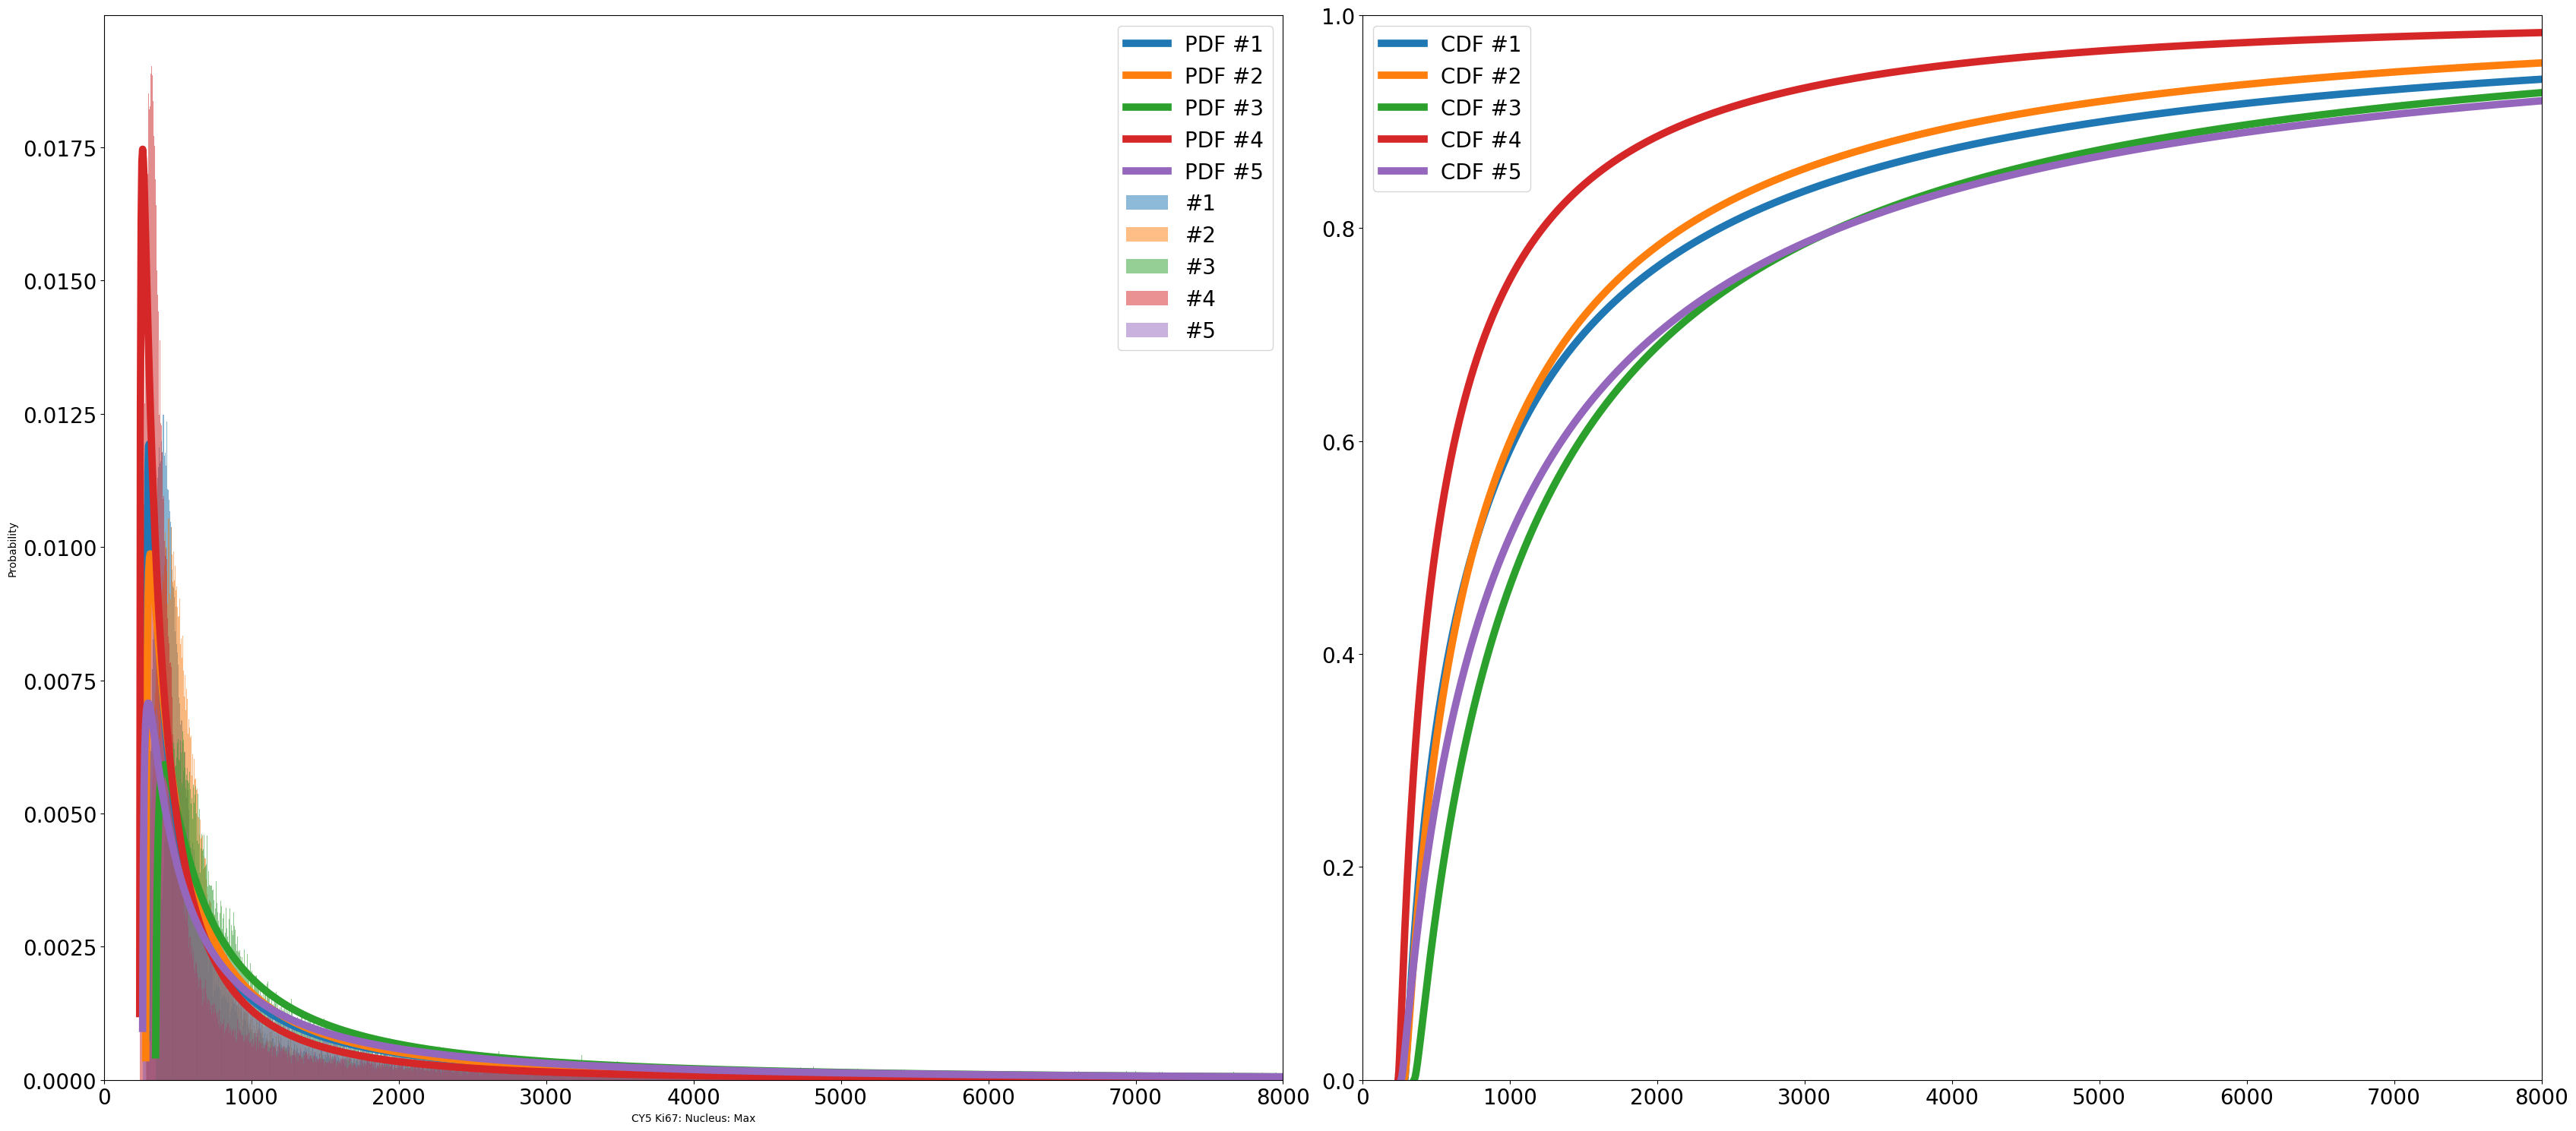

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter
from scipy.stats import lognorm

# Define folder and file paths
folder_path = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/measurements_distribution"

file_paths = [
    "20252602_Image_AsPC LZ GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv"
]

# Expected column mappings
expected_columns = {
    "Class": ["Class"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["FITC KER: Cytoplasm: Median"],
    "Ki67_647": ["CY5 Ki67: Nucleus: Max"],
    "FN_568": ["TRITC FN: Cell: Median"],
    "Nucleus_Area": ["Nucleus: Area µm^2"]
}

# Define bin sizes for each channel
bin_sizes = {"DAPI": 150, "Ki67_647": 5, "KER_488": 50, "FN_568": 20}

# Load and preprocess data
dfs, column_mapping = load_and_preprocess_files(folder_path, file_paths, expected_columns)

# Initialize plots
fig, axs = plt.subplots(1, 2, figsize=(34, 15))

# Define bin width for histogram and fitting
bin_width = bin_sizes.get("Ki67_647", 5)

# Placeholder for storing reference distribution parameters
params_reference = None
threshold_reference = 950  # Example threshold value to translate

for idx, df in enumerate(dfs):
    image_name = df["Image"].iloc[0]
    gem_number = f"#{idx + 1}"
    # image_color = image_colors.get(image_name, "gray")
    pNDRG1_col = column_mapping.get("Ki67_647", "Ki67_647: Nuclear: Max")

    # Define bin edges based on min and max values
    min_val = df[pNDRG1_col].min()
    max_val = df[pNDRG1_col].max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Fit log-normal distribution
    f = Fitter(df[pNDRG1_col], distributions=["lognorm"])
    f.fit()
    params = f.get_best(method="sumsquare_error").get("lognorm", {})

    if idx == 0:
        params_reference = params
    else:
        cdf_reference = lognorm.cdf(threshold_reference, **params_reference)
        translated_threshold = lognorm.ppf(cdf_reference, **params)
        scaled_threshold = (threshold_reference - params_reference['loc']) * (params['scale'] / params_reference['scale']) + params['loc']
        print(f"Translated threshold for img{idx}: {image_name}; {translated_threshold:.2f}")
        print(f"Scaled threshold for img{idx}: {scaled_threshold:.2f}")
        print("params_reference", params_reference)
        print("params", params)
        
    # Plot histograms and fitted distributions
    sns.histplot(df[pNDRG1_col], bins=bins, kde=False, ax=axs[0], alpha=0.5, stat='probability', label=gem_number)
    pdf_values = lognorm.pdf(bins, *params.values()) * bin_width
    cdf_values = lognorm.cdf(bins, *params.values())
    axs[0].plot(bins, pdf_values, label=f"PDF {gem_number}", linewidth=7)
    axs[1].plot(bins, cdf_values, label=f"CDF {gem_number}", linewidth=7)
    axs[1].set_ylim(0, 1)

for ax in axs:
    ax.legend(fontsize=20)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlim(0, 8000)

plt.tight_layout()
# plt.savefig(os.path.join(folder_path, "fitted_measurements_distribution_pNDRG1.png"), dpi=300)
# plt.show()

### KER histograms

#### Finding the right distributions; result = lognormal (4 out of 8) + 3 inv gauss which is very similar


🔹 Processing: 20252602_Image_AsPC LZ GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
✅ Available Columns: ['Image', 'Class', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'FITC KER: Nucleus: Mean', 'FITC KER: Nucleus: 

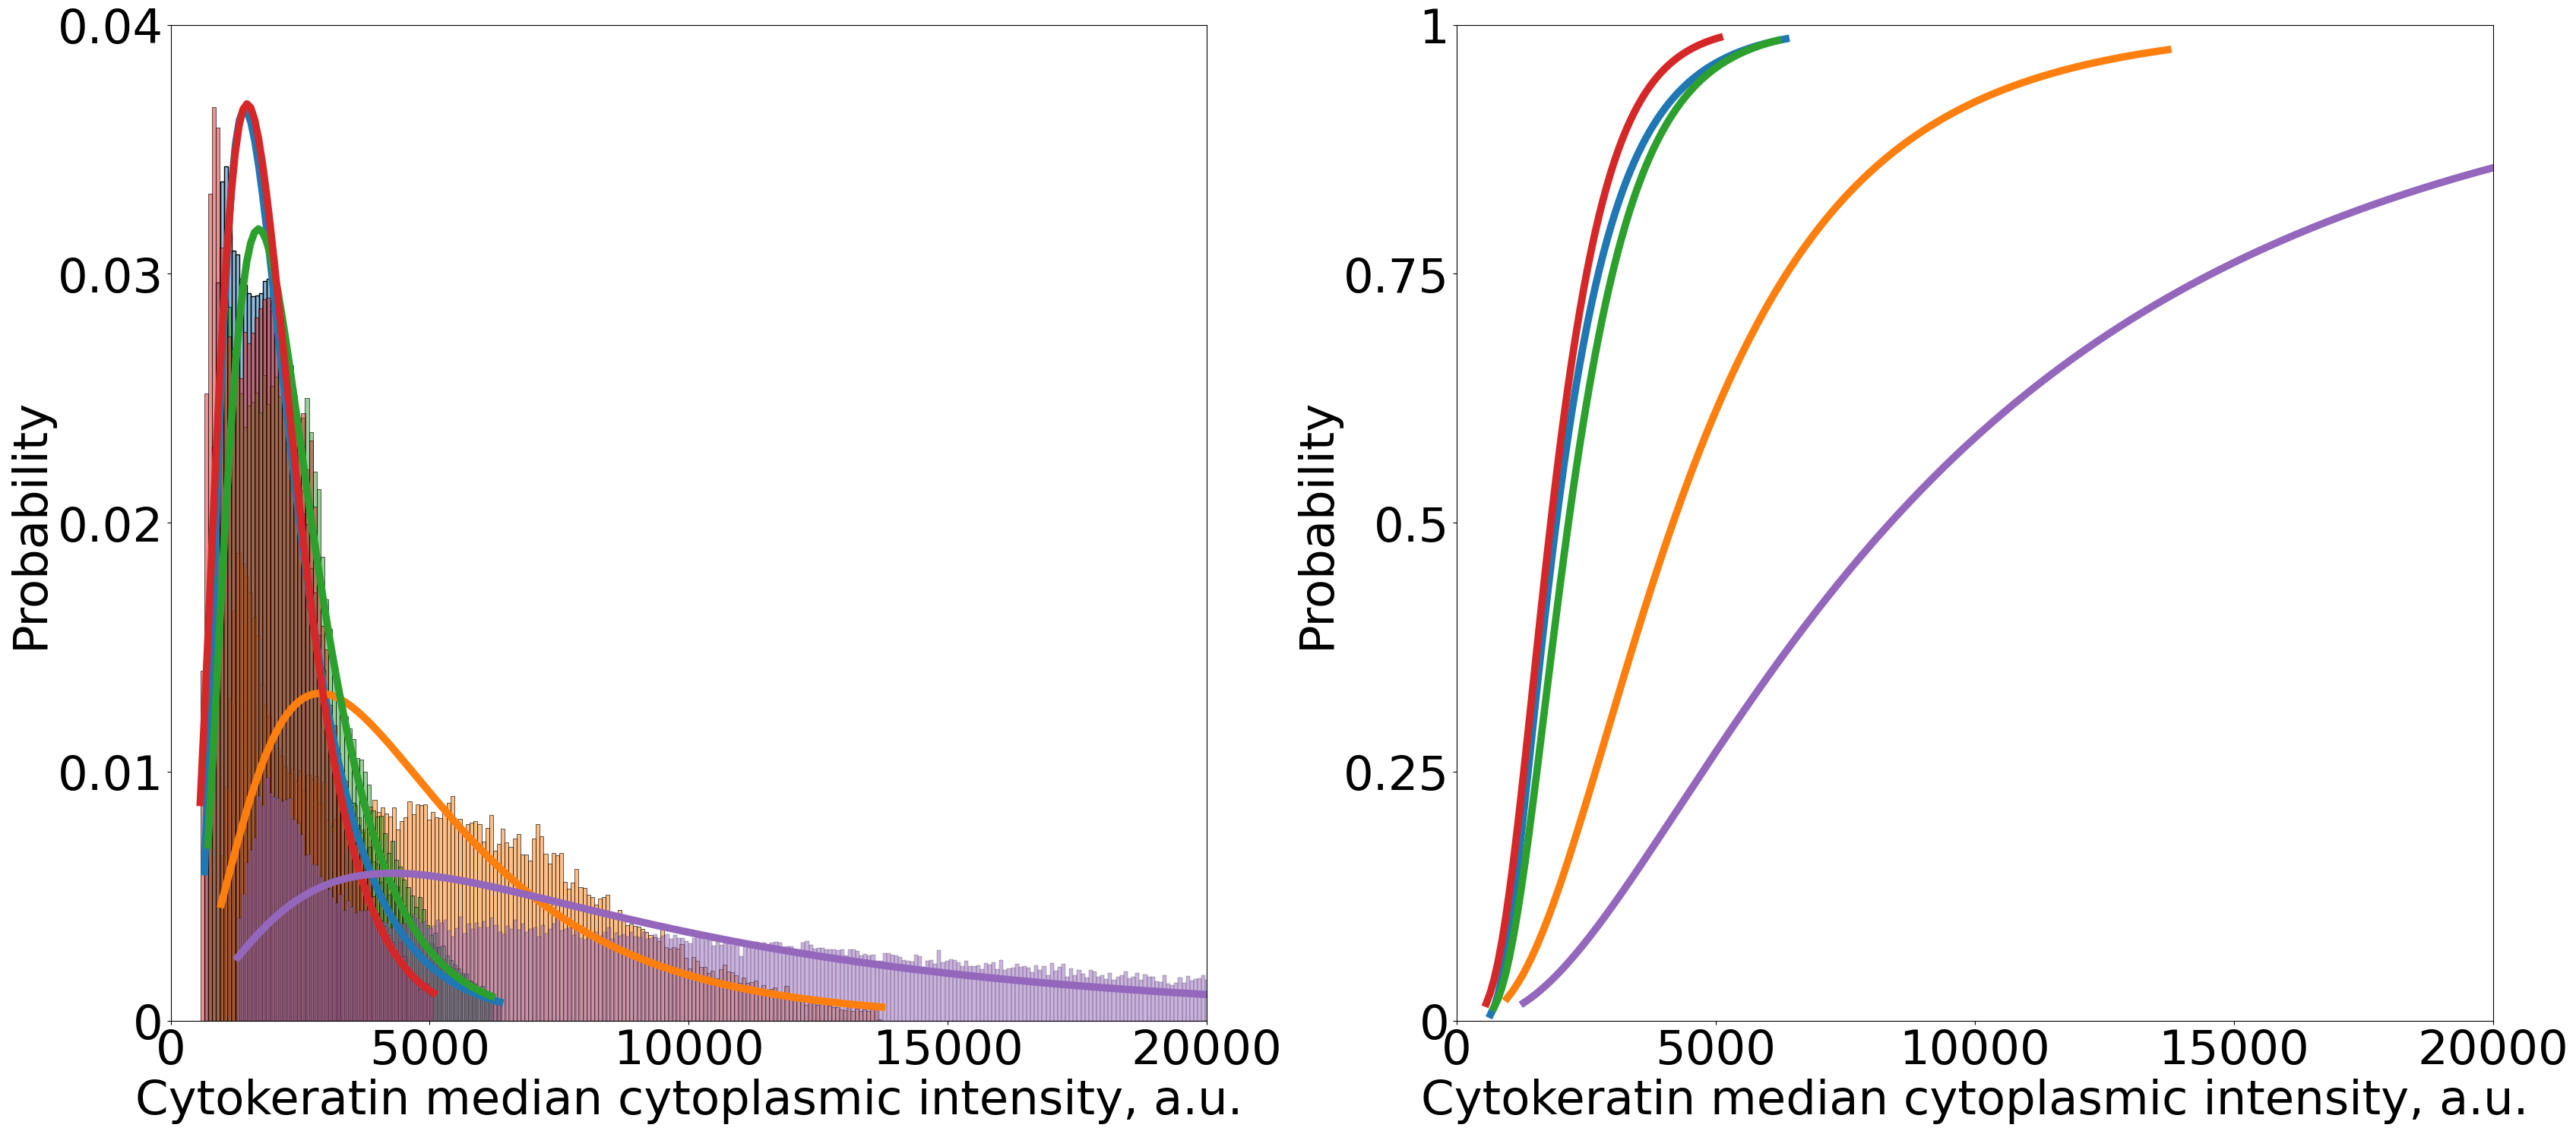

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter
from scipy.stats import lognorm

# Define folder and file paths
folder_path = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/measurements_distribution"

file_paths = [
    "20252602_Image_AsPC LZ GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv"
]

# Define bin sizes for each channel
bin_sizes = {
    "DAPI": 50,
    "Ki67_647": 5,
    "KER_488": 75,
    "FN_568": 40
}

expected_columns = {
    "Class": ["Class"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["FITC KER: Cytoplasm: Median"],
    "Ki67_647": ["CY5 Ki67: Nucleus: Max"],
    "FN_568": ["TRITC FN: Cell: Median"],
    "Nucleus_Area": ["Nucleus: Area µm^2"]
}

# Define axis labels and limits
axis_labels = {
    "PDF": "Cytokeratin median cytoplasmic intensity, a.u.",
    "CDF": "Cytokeratin median cytoplasmic intensity, a.u."
}
axis_limits = {
    "PDF": (0, 20000),
    "CDF": (0, 20000)
}


# Load and preprocess data
dfs, column_mapping = load_and_preprocess_files(folder_path, file_paths, expected_columns)

# Initialize plots
fig, axs = plt.subplots(1, 2, figsize=(34, 15))

# Define bin width for histogram and fitting
bin_width = bin_sizes.get("KER_488", 5)

for idx, df in enumerate(dfs):
    image_name = df["Image"].iloc[0]
    gem_number = f"#{idx + 1}"

    # Get relevant column name
    pNDRG1_col = column_mapping.get("KER_488", "KER_488: Nucleus: Max")

    # Define bin edges based on min and max values
    min_val = df[pNDRG1_col].min()
    max_val = df[pNDRG1_col].max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Fit log-normal distribution
    f = Fitter(df[pNDRG1_col], distributions=["lognorm"])
    f.fit()
    params = f.get_best(method="sumsquare_error").get("lognorm", {})

    # Compute fitted PDF and CDF at the same resolution as histogram
    pdf_values = lognorm.pdf(bins, *params.values())
    cdf_values = lognorm.cdf(bins, *params.values())
    pdf_values *= bin_width

    # Overlay histogram and best-fit PDF
    sns.histplot(df[pNDRG1_col], 
                 bins=bins, 
                 kde=False,
                 ax=axs[0], 
                 label=f'{gem_number}',
                 alpha=0.5,
                 stat='probability')
    axs[0].plot(bins, pdf_values, label=f"PDF {gem_number}", linewidth=7)

    # Plot CDF separately
    axs[1].plot(bins, cdf_values, label=f'CDF {gem_number}', linewidth=7)
    axs[1].set_ylim(0, 1)
# Apply formatting to match your layout
for key, ax in zip(["PDF", "CDF"], axs):
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set_ylabel('Probability', fontsize=45)
    ax.set_xlabel(axis_labels[key], fontsize=45)
    ax.tick_params(axis='both', labelsize=45)

    # Set x-axis range and define 5 evenly spaced ticks
    if key in axis_limits:
        ax.set_xlim(axis_limits[key])
        xticks = np.linspace(axis_limits[key][0], axis_limits[key][1], 5)
        ax.set_xticks(xticks)

    # Ensure y-axis tick limits apply to all panels
    yticks = ax.get_yticks()
    if len(yticks) > 5:  
        min_y, max_y = min(yticks), max(yticks)  
        yticks = np.linspace(min_y, max_y, 5)  
        ax.set_yticks(yticks)

    # Format y-tick labels to 2 significant digits
    ax.set_yticklabels([f"{tick:.2g}" for tick in yticks])

plt.tight_layout()
plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/measurements_distribution/2025_fitted_measurements_distribution_KER_488.png", dpi=300)
plt.show()



🔹 Processing: 20252602_Image_AsPC LZ GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
✅ Available Columns: ['Image', 'Class', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'FITC KER: Nucleus: Mean', 'FITC KER: Nucleus: 

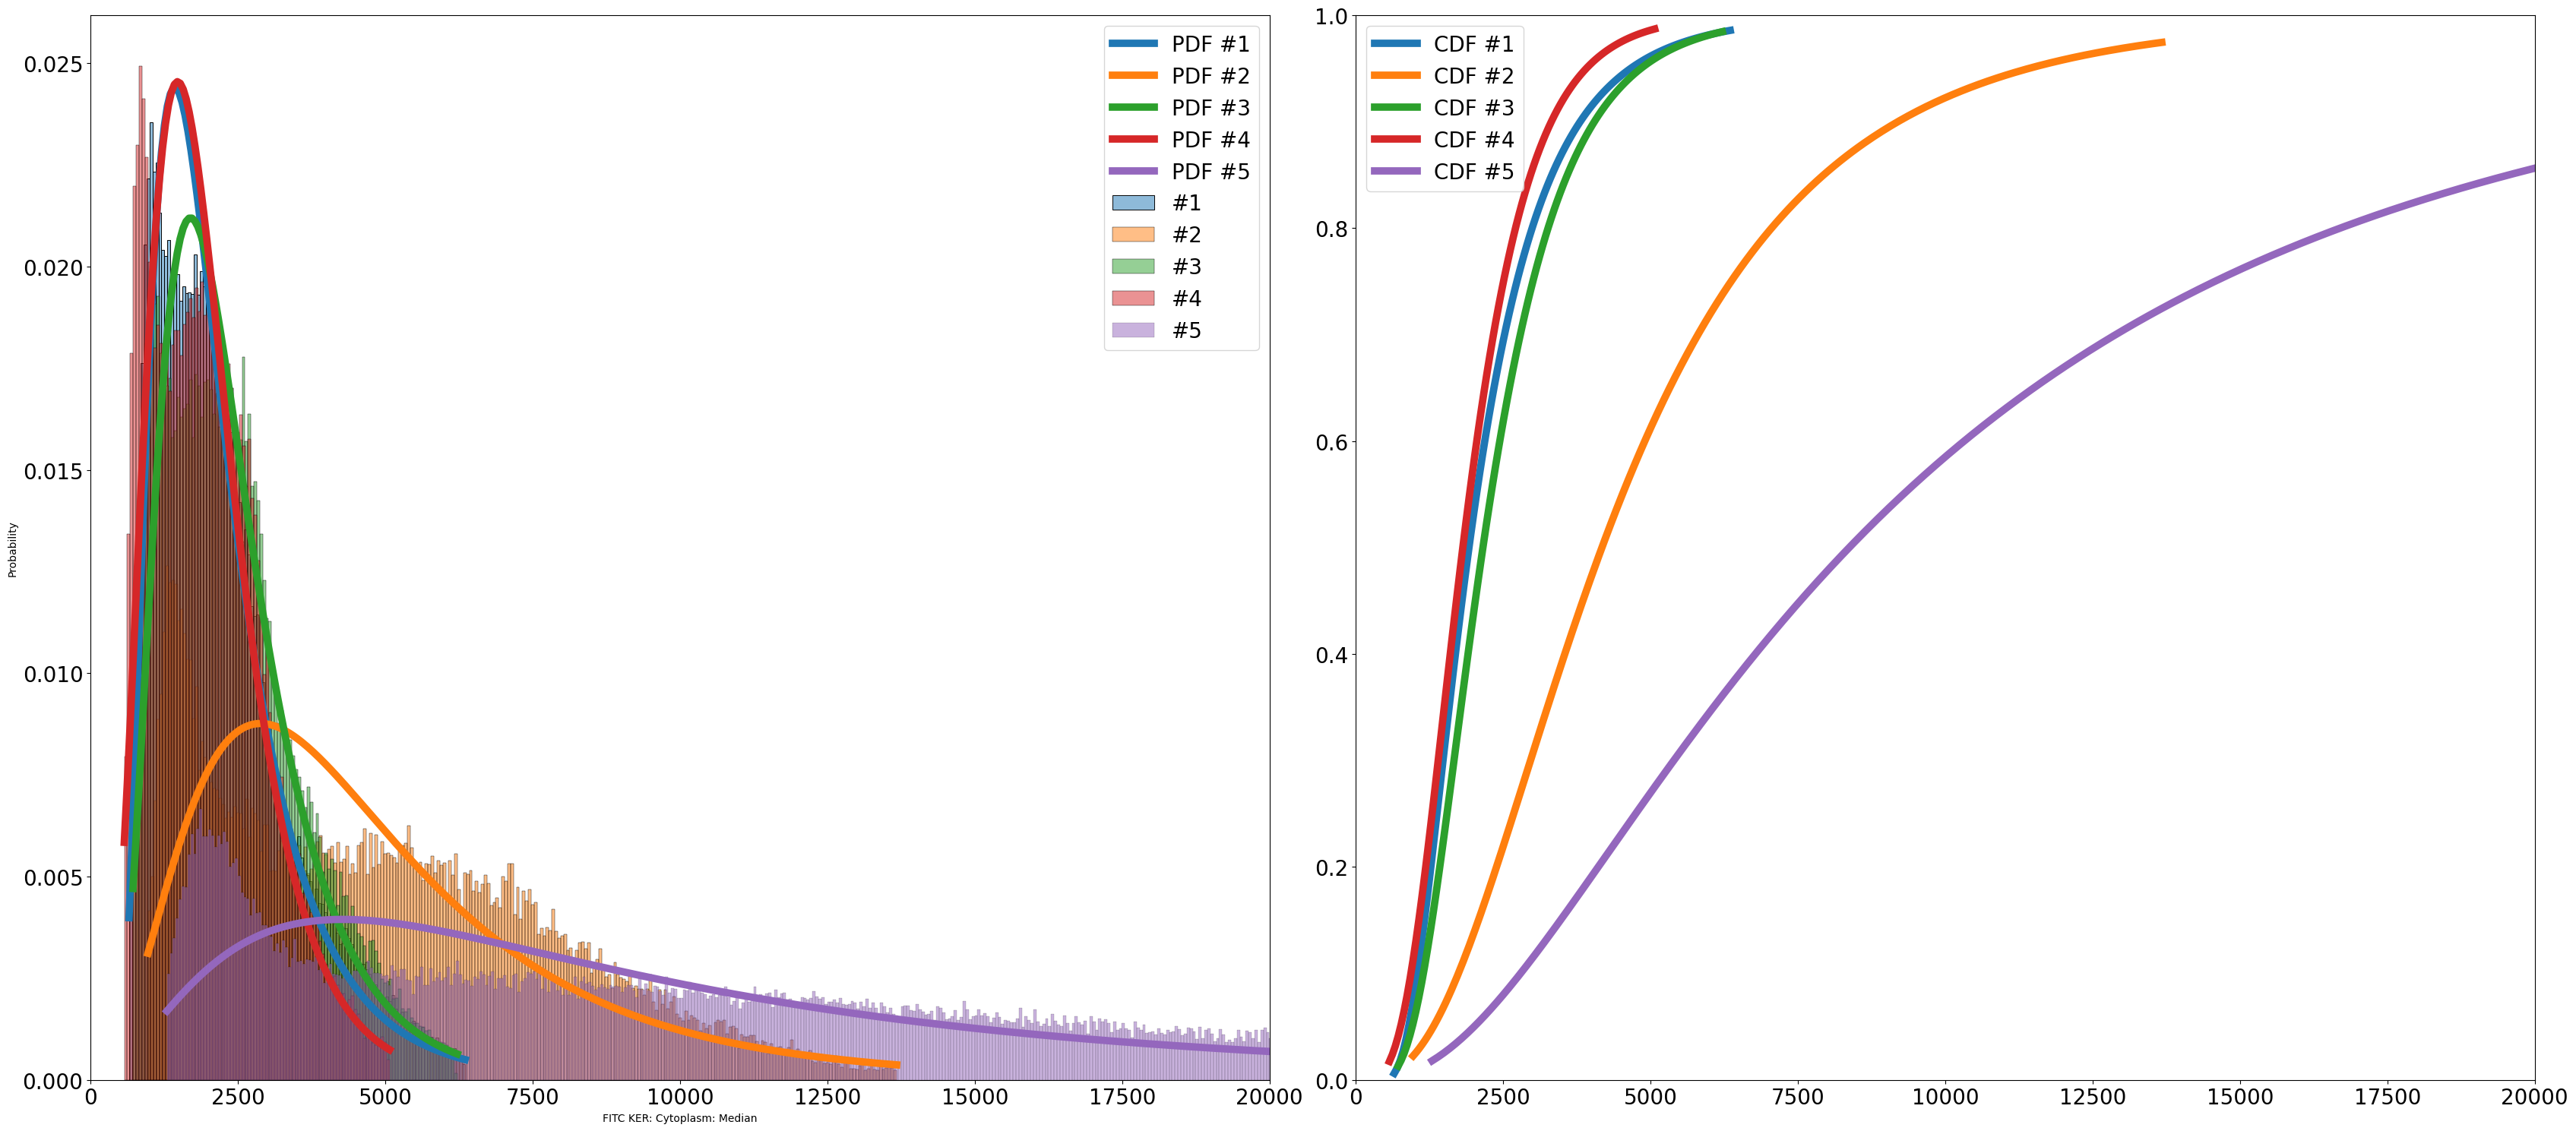

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter
from scipy.stats import lognorm

# Define folder and file paths
folder_path = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/measurements_distribution"

file_paths = [
    "20252602_Image_AsPC LZ GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv"
]

# Expected column mappings
expected_columns = {
    "Class": ["Class"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["FITC KER: Cytoplasm: Median"],
    "Ki67_647": ["CY5 Ki67: Nucleus: Max"],
    "FN_568": ["TRITC FN: Cell: Median"],
    "Nucleus_Area": ["Nucleus: Area µm^2"]
}

# Define bin sizes for each channel
bin_sizes = {"DAPI": 150, "Ki67_647": 5, "KER_488": 50, "FN_568": 20}

# Load and preprocess data
dfs, column_mapping = load_and_preprocess_files(folder_path, file_paths, expected_columns)

# Initialize plots
fig, axs = plt.subplots(1, 2, figsize=(34, 15))

# Define bin width for histogram and fitting
bin_width = bin_sizes.get("KER_488", 50)

# Placeholder for storing reference distribution parameters
params_reference = None
threshold_reference = 650  # Example threshold value to translate

for idx, df in enumerate(dfs):
    image_name = df["Image"].iloc[0]
    gem_number = f"#{idx + 1}"
    # image_color = image_colors.get(image_name, "gray")
    pNDRG1_col = column_mapping.get("KER_488", "KER_488: Cytoplasm: Median")

    # Define bin edges based on min and max values
    min_val = df[pNDRG1_col].min()
    max_val = df[pNDRG1_col].max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Fit log-normal distribution
    f = Fitter(df[pNDRG1_col], distributions=["lognorm"])
    f.fit()
    params = f.get_best(method="sumsquare_error").get("lognorm", {})

    if idx == 0:
        params_reference = params
    else:
        cdf_reference = lognorm.cdf(threshold_reference, **params_reference)
        translated_threshold = lognorm.ppf(cdf_reference, **params)
        scaled_threshold = (threshold_reference - params_reference['loc']) * (params['scale'] / params_reference['scale']) + params['loc']
        print(f"Translated threshold for img{idx}: {image_name}; {translated_threshold:.2f}")
        print(f"Scaled threshold for img{idx}: {scaled_threshold:.2f}")
        print("params_reference", params_reference)
        print("params", params)
        
    # Plot histograms and fitted distributions
    sns.histplot(df[pNDRG1_col], bins=bins, kde=False, ax=axs[0], alpha=0.5, stat='probability', label=gem_number)
    pdf_values = lognorm.pdf(bins, *params.values()) * bin_width
    cdf_values = lognorm.cdf(bins, *params.values())
    axs[0].plot(bins, pdf_values, label=f"PDF {gem_number}", linewidth=7)
    axs[1].plot(bins, cdf_values, label=f"CDF {gem_number}", linewidth=7)
    axs[1].set_ylim(0, 1)

for ax in axs:
    ax.legend(fontsize=20)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlim(0, 20000)

plt.tight_layout()
# plt.savefig(os.path.join(folder_path, "fitted_measurements_distribution_pNDRG1.png"), dpi=300)
# plt.show()

### FN histograms

#### Finding the right distributions; result = lognormal (4 out of 8) + 3 inv gauss which is very similar


🔹 Processing: 20252602_Image_AsPC LZ GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
✅ Available Columns: ['Image', 'Class', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'FITC KER: Nucleus: Mean', 'FITC KER: Nucleus: 

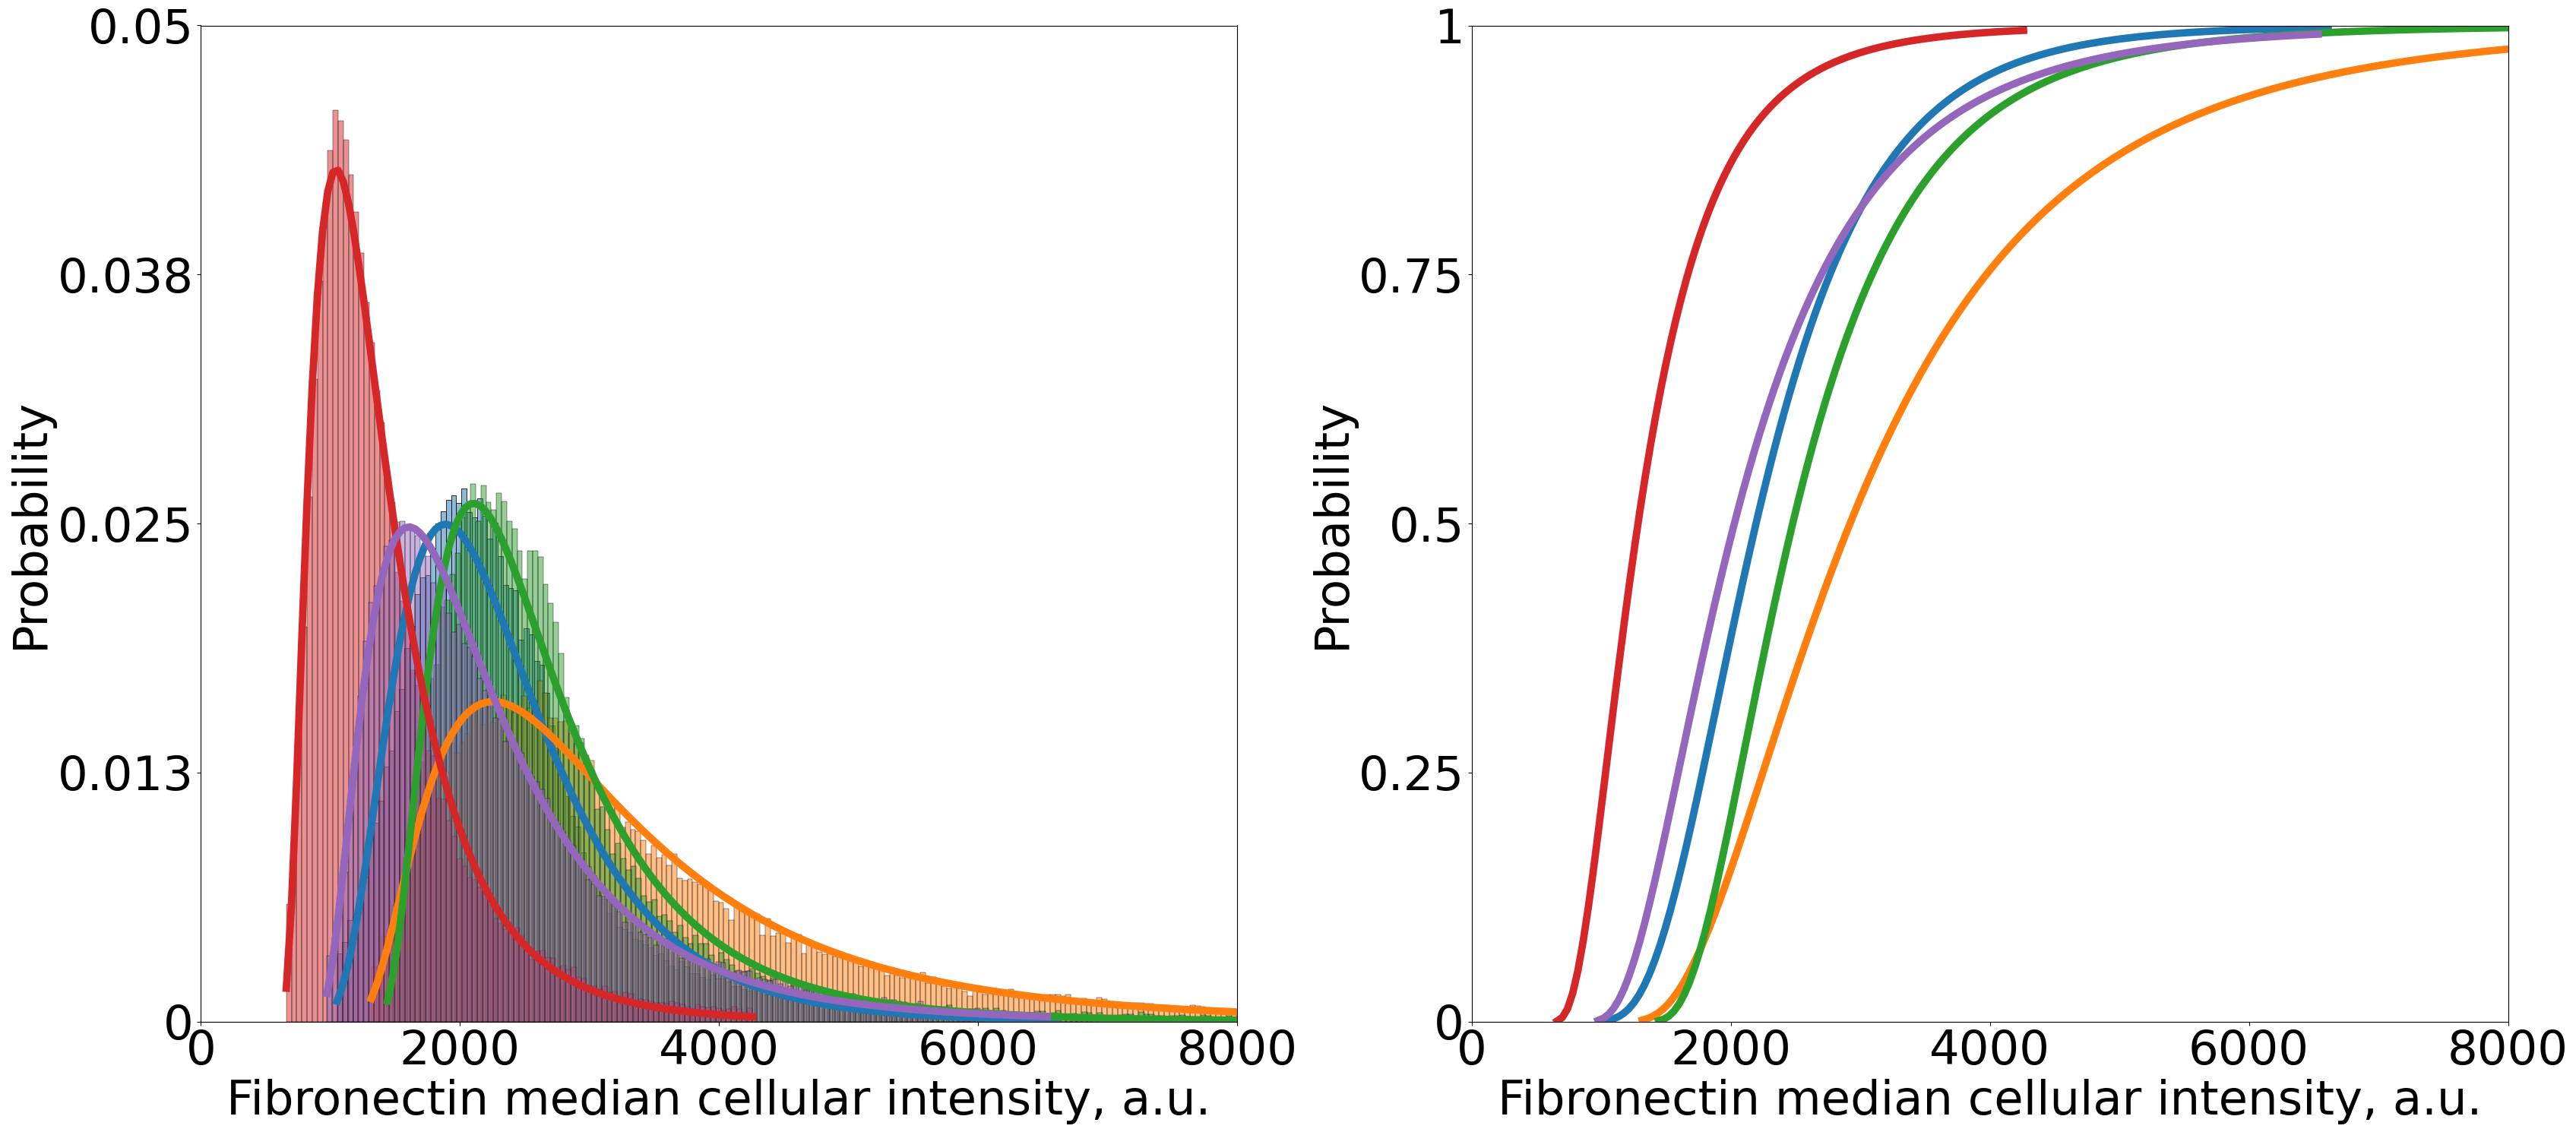

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter
from scipy.stats import lognorm

# Define folder and file paths
folder_path = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/measurements_distribution"

file_paths = [
    "20252602_Image_AsPC LZ GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv"
]

# Define bin sizes for each channel
bin_sizes = {
    "DAPI": 50,
    "Ki67_647": 5,
    "KER_488": 75,
    "FN_568": 40
}

expected_columns = {
    "Class": ["Class"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["FITC KER: Cytoplasm: Median"],
    "Ki67_647": ["CY5 Ki67: Nucleus: Max"],
    "FN_568": ["TRITC FN: Cell: Median"],
    "Nucleus_Area": ["Nucleus: Area µm^2"]
}

# Define axis labels and limits
axis_labels = {
    "PDF": "Fibronectin median cellular intensity, a.u.",
    "CDF": "Fibronectin median cellular intensity, a.u."
}
axis_limits = {
    "PDF": (0, 8000),
    "CDF": (0, 8000)
}


# Load and preprocess data
dfs, column_mapping = load_and_preprocess_files(folder_path, file_paths, expected_columns)

# Initialize plots
fig, axs = plt.subplots(1, 2, figsize=(34, 15))

# Define bin width for histogram and fitting
bin_width = bin_sizes.get("FN_568", 5)

for idx, df in enumerate(dfs):
    image_name = df["Image"].iloc[0]
    gem_number = f"#{idx + 1}"

    # Get relevant column name
    pNDRG1_col = column_mapping.get("FN_568", "FN_568: Cell: Median")

    # Define bin edges based on min and max values
    min_val = df[pNDRG1_col].min()
    max_val = df[pNDRG1_col].max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Fit log-normal distribution
    f = Fitter(df[pNDRG1_col], distributions=["lognorm"])
    f.fit()
    params = f.get_best(method="sumsquare_error").get("lognorm", {})

    # Compute fitted PDF and CDF at the same resolution as histogram
    pdf_values = lognorm.pdf(bins, *params.values())
    cdf_values = lognorm.cdf(bins, *params.values())
    pdf_values *= bin_width

    # Overlay histogram and best-fit PDF
    sns.histplot(df[pNDRG1_col], 
                 bins=bins, 
                 kde=False,
                 ax=axs[0], 
                 label=f'{gem_number}',
                 alpha=0.5,
                 stat='probability')
    axs[0].plot(bins, pdf_values, label=f"PDF {gem_number}", linewidth=7)

    # Plot CDF separately
    axs[1].plot(bins, cdf_values, label=f'CDF {gem_number}', linewidth=7)
    axs[1].set_ylim(0, 1)
# Apply formatting to match your layout
for key, ax in zip(["PDF", "CDF"], axs):
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set_ylabel('Probability', fontsize=45)
    ax.set_xlabel(axis_labels[key], fontsize=45)
    ax.tick_params(axis='both', labelsize=45)

    # Set x-axis range and define 5 evenly spaced ticks
    if key in axis_limits:
        ax.set_xlim(axis_limits[key])
        xticks = np.linspace(axis_limits[key][0], axis_limits[key][1], 5)
        ax.set_xticks(xticks)

    # Ensure y-axis tick limits apply to all panels
    yticks = ax.get_yticks()
    if len(yticks) > 5:  
        min_y, max_y = min(yticks), max(yticks)  
        yticks = np.linspace(min_y, max_y, 5)  
        ax.set_yticks(yticks)

    # Format y-tick labels to 2 significant digits
    ax.set_yticklabels([f"{tick:.2g}" for tick in yticks])

plt.tight_layout()
plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/measurements_distribution/2025_fitted_measurements_distribution_FN_568.png", dpi=300)
plt.show()



🔹 Processing: 20252602_Image_AsPC LZ GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
✅ Available Columns: ['Image', 'Class', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'FITC KER: Nucleus: Mean', 'FITC KER: Nucleus: 

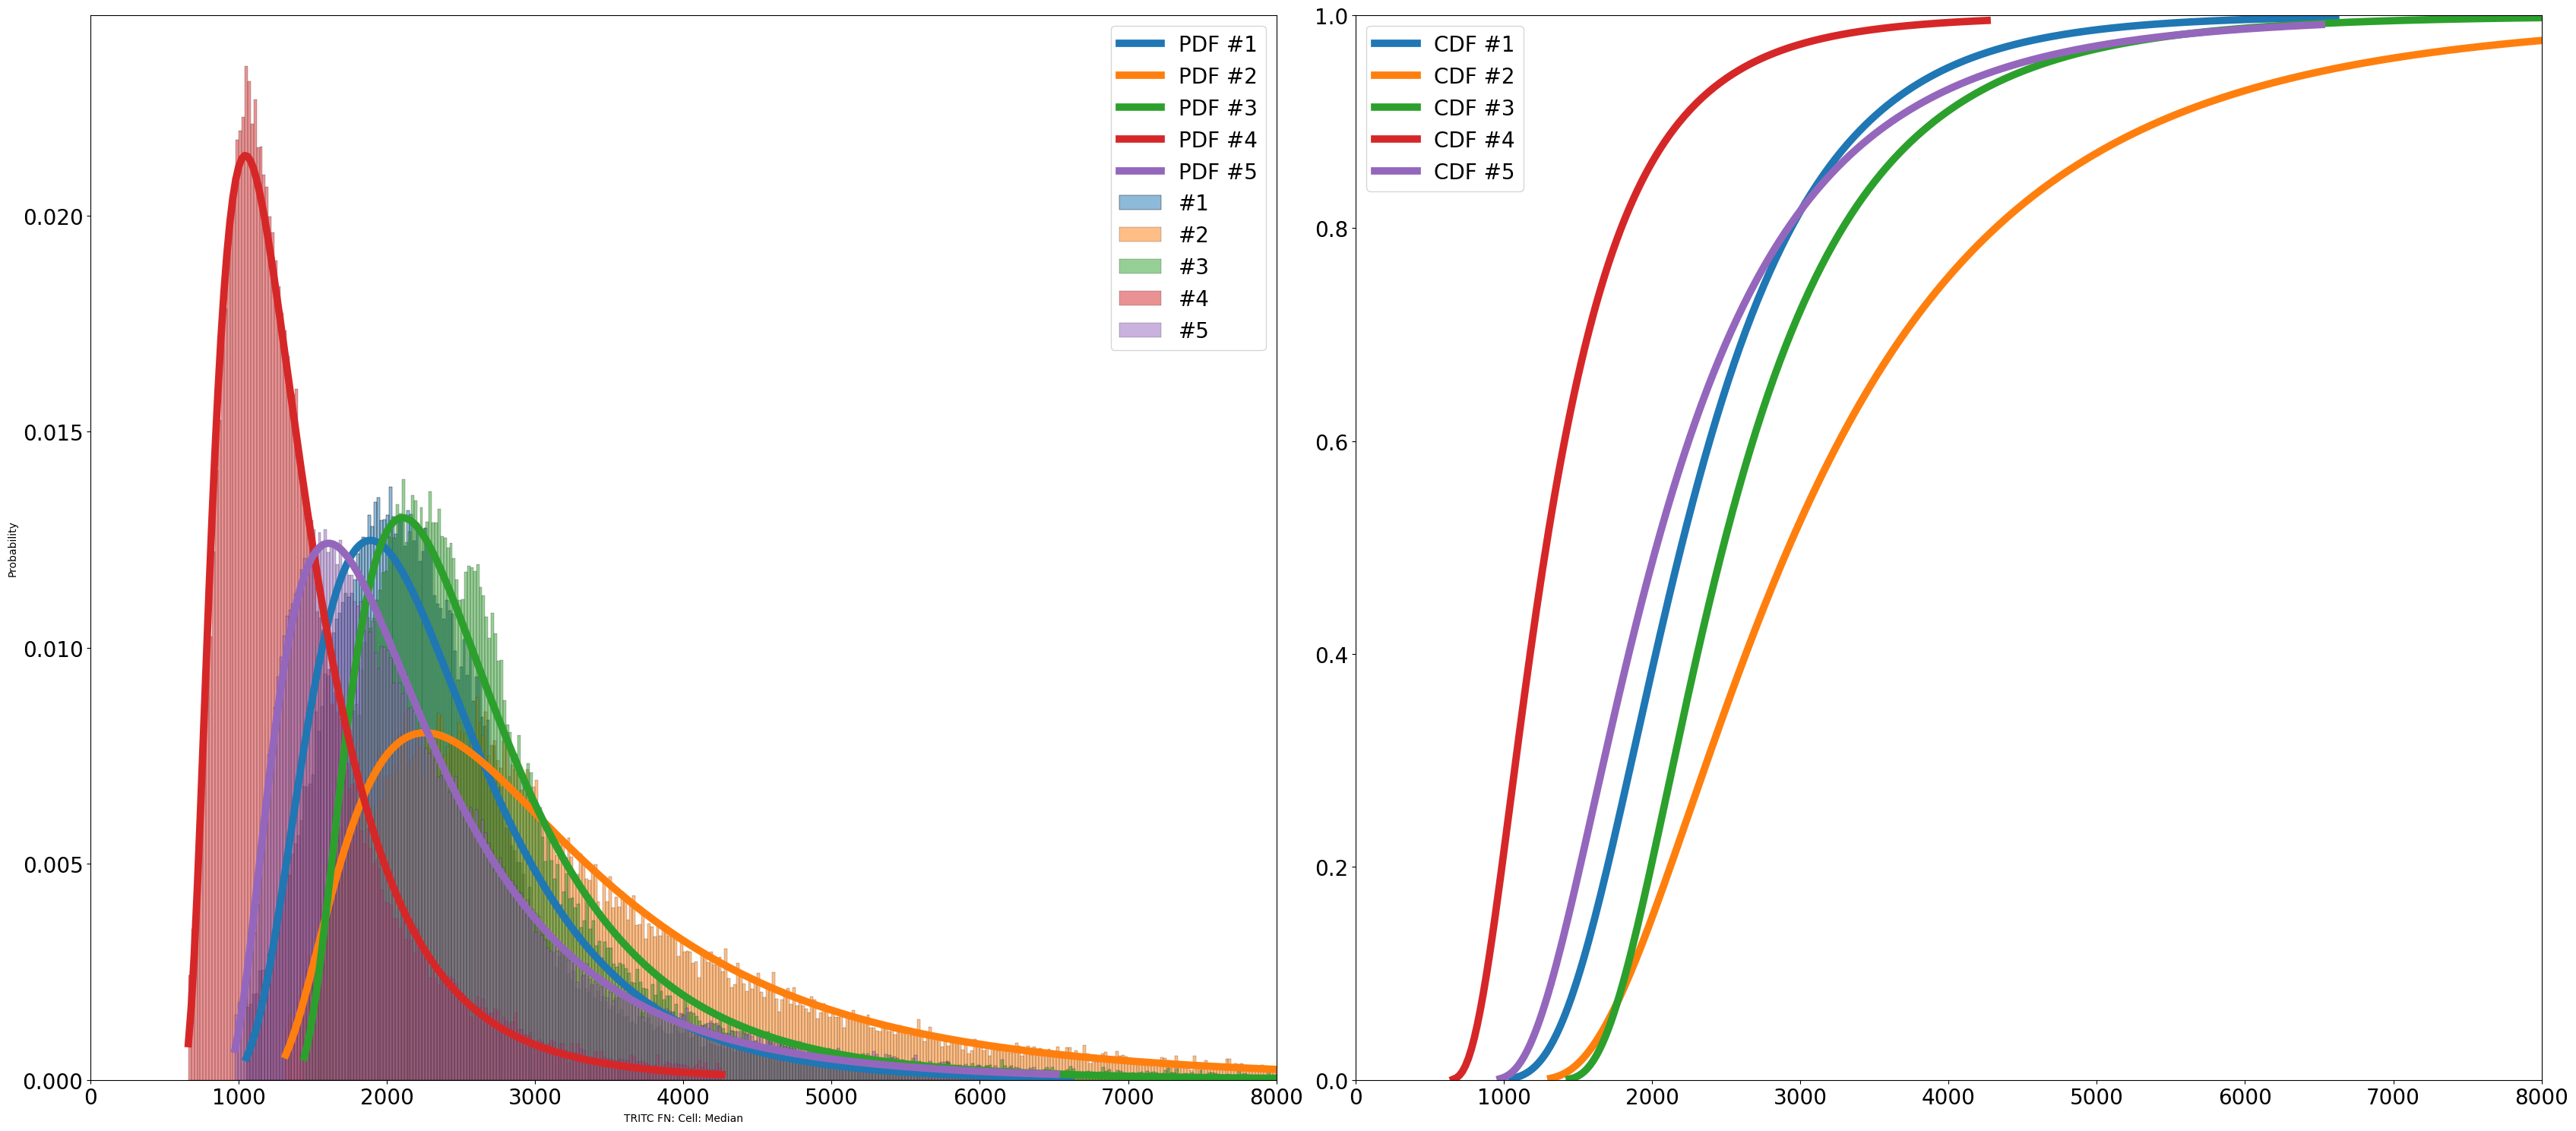

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter
from scipy.stats import lognorm

# Define folder and file paths
folder_path = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/measurements_distribution"

file_paths = [
    "20252602_Image_AsPC LZ GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv",
    "20252602_Image_AsPC LZ GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv"
]

# Expected column mappings
expected_columns = {
    "Class": ["Class"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["FITC KER: Cytoplasm: Median"],
    "Ki67_647": ["CY5 Ki67: Nucleus: Max"],
    "FN_568": ["TRITC FN: Cell: Median"],
    "Nucleus_Area": ["Nucleus: Area µm^2"]
}

# Define bin sizes for each channel
bin_sizes = {"DAPI": 150, "Ki67_647": 5, "KER_488": 50, "FN_568": 20}

# Load and preprocess data
dfs, column_mapping = load_and_preprocess_files(folder_path, file_paths, expected_columns)

# Initialize plots
fig, axs = plt.subplots(1, 2, figsize=(34, 15))

# Define bin width for histogram and fitting
bin_width = bin_sizes.get("FN_568", 5)

# Placeholder for storing reference distribution parameters
params_reference = None
threshold_reference = 4000  # Example threshold value to translate

for idx, df in enumerate(dfs):
    image_name = df["Image"].iloc[0]
    gem_number = f"#{idx + 1}"
    # image_color = image_colors.get(image_name, "gray")
    pNDRG1_col = column_mapping.get("FN_568", "FN_568: Cell: Median")

    # Define bin edges based on min and max values
    min_val = df[pNDRG1_col].min()
    max_val = df[pNDRG1_col].max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Fit log-normal distribution
    f = Fitter(df[pNDRG1_col], distributions=["lognorm"])
    f.fit()
    params = f.get_best(method="sumsquare_error").get("lognorm", {})

    if idx == 0:
        params_reference = params
    else:
        cdf_reference = lognorm.cdf(threshold_reference, **params_reference)
        translated_threshold = lognorm.ppf(cdf_reference, **params)
        scaled_threshold = (threshold_reference - params_reference['loc']) * (params['scale'] / params_reference['scale']) + params['loc']
        print(f"Translated threshold for img{idx}: {image_name}; {translated_threshold:.2f}")
        print(f"Scaled threshold for img{idx}: {scaled_threshold:.2f}")
        print("params_reference", params_reference)
        print("params", params)
        
    # Plot histograms and fitted distributions
    sns.histplot(df[pNDRG1_col], bins=bins, kde=False, ax=axs[0], alpha=0.5, stat='probability', label=gem_number)
    pdf_values = lognorm.pdf(bins, *params.values()) * bin_width
    cdf_values = lognorm.cdf(bins, *params.values())
    axs[0].plot(bins, pdf_values, label=f"PDF {gem_number}", linewidth=7)
    axs[1].plot(bins, cdf_values, label=f"CDF {gem_number}", linewidth=7)
    axs[1].set_ylim(0, 1)

for ax in axs:
    ax.legend(fontsize=20)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlim(0, 8000)

plt.tight_layout()
# plt.savefig(os.path.join(folder_path, "fitted_measurements_distribution_pNDRG1.png"), dpi=300)
# plt.show()
